# Importing Libraries

In [1]:
# # Imports Pandas and numpy for data manipulation, Matplotlib for data visualization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split


In [2]:
# Reading Data from csv file

data = pd.read_csv('kaggle_loan_data.csv')

C:\Users\denizhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (135,204,274,417) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Exploration and Cleaning

In [3]:
# # We find missing values for each parameter

# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [4]:
# We can see how many missing value each parameter has
missing_values_table(data).head(50)

Your selected dataframe has 771 columns.
There are 525 columns that have missing values.


,Missing Values,% of Total Values
f662,18833,17.9
f663,18833,17.9
f159,18736,17.8
f160,18736,17.8
f170,18417,17.5
f169,18417,17.5
f618,18407,17.5
f619,18407,17.5
f331,18067,17.1
f330,18067,17.1


In [5]:
# We fill missing values by replacing them with mean
data.fillna(data.mean(), inplace=True)

In [6]:
# To check there are still missing values
missing_values_table(data).head(50)

Your selected dataframe has 771 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
f206,1291,1.2
f207,1291,1.2
f390,698,0.7
f391,698,0.7
f626,698,0.7
f627,698,0.7
f695,698,0.7
f698,698,0.7
f138,182,0.2
f137,177,0.2


In [7]:
# We drop remaining observations with missing values
data.dropna(inplace=True)
missing_values_table(data)

Your selected dataframe has 771 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [8]:
# # # Exploratory Data Analysis

for i in data.select_dtypes(include=['object']).columns:
    data.drop(labels=i, axis=1, inplace=True)

In [9]:
# # We explore correlation between parameters and loss

# Find all correlations and sort 
correlations_data = data.corr()['loss'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

f612   -0.016943
f776   -0.015111
f315   -0.011106
f70    -0.010740
f314   -0.010689
f323   -0.010676
f69    -0.010269
f322   -0.009299
f734   -0.009284
f738   -0.008635
f1     -0.008162
f631   -0.008097
f428   -0.007973
f666   -0.007868
f299   -0.007778
Name: loss, dtype: float64 

f674    0.018999
f536    0.026087
f471    0.039538
loss    1.000000
f33          NaN
f34          NaN
f35          NaN
f37          NaN
f38          NaN
f678         NaN
f700         NaN
f701         NaN
f702         NaN
f736         NaN
f764         NaN
Name: loss, dtype: float64


In [10]:
# We need to remove collinear parameters to increase accuracy and for faster computing

def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between loss
    y = x['loss']
    x = x.drop(columns = ['loss'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the score back in to the data
    x['loss'] = y
               
    return x

In [11]:
# We remove the collinear parameters above a certain treshold

data = remove_collinear_features(data, 0.6);

C:\Users\denizhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater_equal


In [12]:
# To check number of parameters left after removing collinearity
data.shape

(103302, 167)

# Separating Train and Test Data Sets

In [13]:
# Preparation for running Random Forest algorithm 

# We split our data into test and train sets

# Separate out the features and targets
features = data.drop(columns='loss')
targets = pd.DataFrame(data['loss'])

# Split into 80% training and 20% testing set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(82641, 166)
(20661, 166)
(82641, 1)
(20661, 1)


In [14]:
# # We normalize data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
# Convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

# Machine Learning - Random Forest Classification

In [16]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = X_train, y_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))



Feature ranking:
1. feature 112 (0.009354)
2. feature 8 (0.007943)
3. feature 119 (0.007926)
4. feature 102 (0.007490)
5. feature 11 (0.007334)
6. feature 143 (0.007327)
7. feature 58 (0.007319)
8. feature 105 (0.007268)
9. feature 111 (0.007261)
10. feature 70 (0.007196)
11. feature 12 (0.007172)
12. feature 130 (0.007171)
13. feature 126 (0.007161)
14. feature 38 (0.007115)
15. feature 140 (0.007111)
16. feature 13 (0.007109)
17. feature 54 (0.007106)
18. feature 22 (0.007087)
19. feature 39 (0.007086)
20. feature 164 (0.007085)
21. feature 37 (0.007012)
22. feature 64 (0.006993)
23. feature 89 (0.006980)
24. feature 59 (0.006978)
25. feature 21 (0.006961)
26. feature 43 (0.006950)
27. feature 23 (0.006930)
28. feature 45 (0.006927)
29. feature 51 (0.006909)
30. feature 60 (0.006906)
31. feature 71 (0.006903)
32. feature 44 (0.006892)
33. feature 138 (0.006880)
34. feature 82 (0.006875)
35. feature 49 (0.006811)
36. feature 147 (0.006811)
37. feature 27 (0.006808)
38. feature 48 (0.0

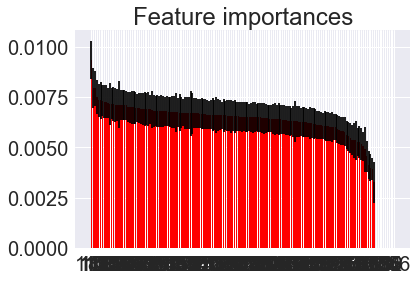

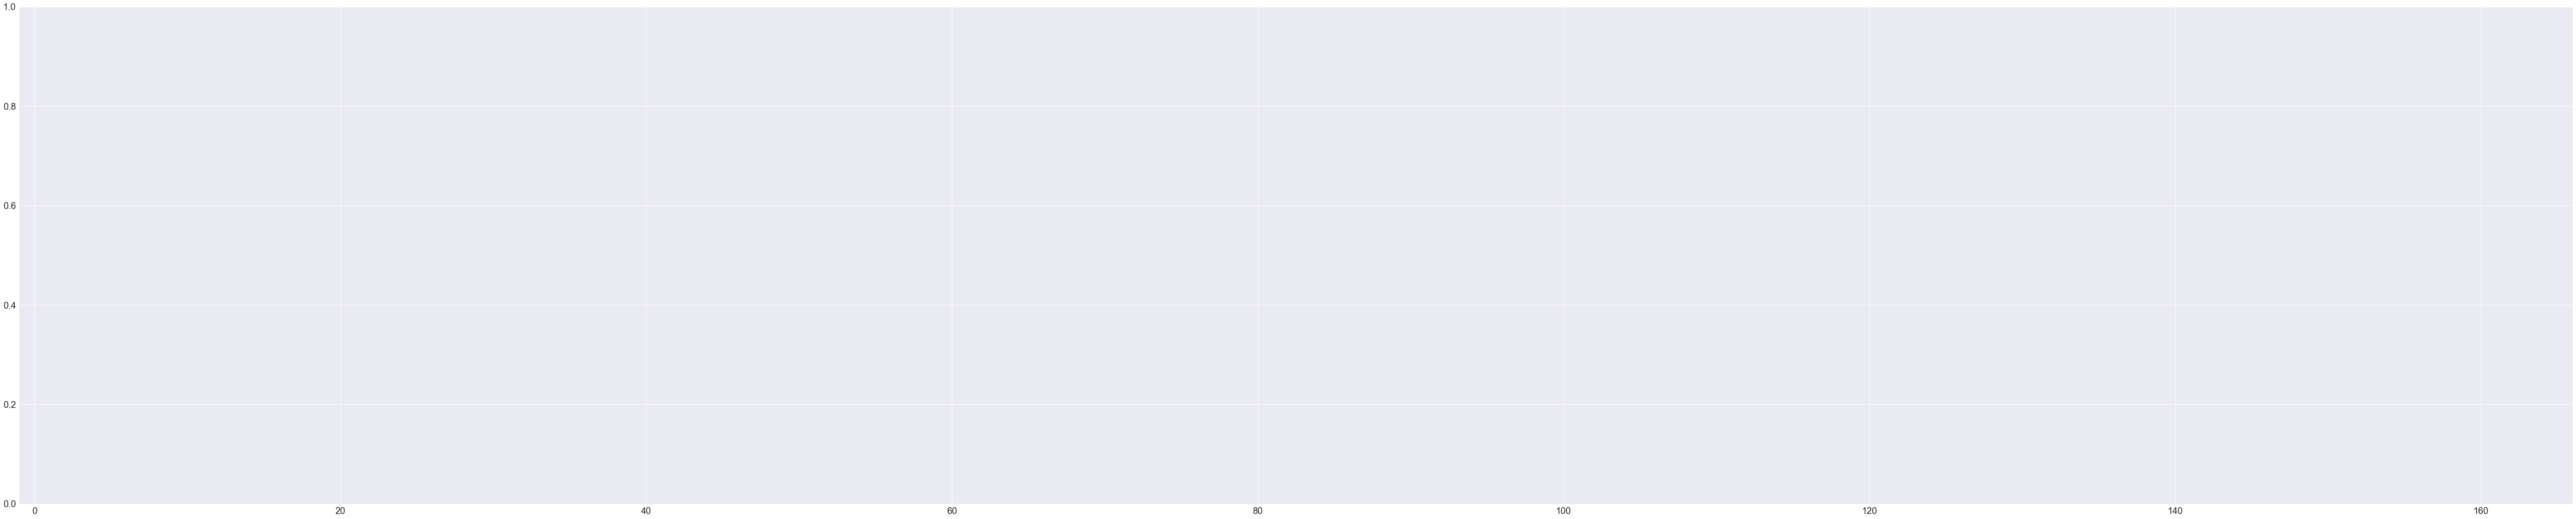

In [21]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.figure(figsize=(100,20))
plt.xlim([-1, X.shape[1]])
plt.show()

In [22]:
#print(importances)
len(X)
#importances.item(1)
#int(importances.item(4)) == 0
print(indices)


[112   8 119 102  11 143  58 105 111  70  12 130 126  38 140  13  54  22
  39 164  37  64  89  59  21  43  23  45  51  60  71  44 138  82  49 147
  27  48 161  63 160  57  97 139  42  83  40   6   9 135 149 133  56 122
  75  74 114  55  25  61  85 150 141 116 158  20  73 109  10  72  62   7
 129  52 136  26  41  94  34  32  96  87   3  66 142 121  29  78 120 145
 101  99 107  95 134   0  79 118 106 108 125 128 117   4 115 153  30  86
 146 162 144  80  24 137 104  28 103  68 157  46 151  88 148 110  98  93
 113   1  36  92  91 123  90  77 124  76   5 100  17   2  35  33  67  65
  50  69  84  31  53  81  47 131 127 132 165 163 159  19  18 155 154 152
  14  15  16 156]


# Cross Validation

In [23]:
# Cross Validation Calculation with Mean Absolute Error

# Function to calculate mean absolute error
def cross_val(X_train, y_train, model):
    # Applying k-Fold Cross Validation
    from sklearn.model_selection import cross_val_score
    accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
    return accuracies.mean()

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_cross = cross_val(X_train, y_train, model)
    
    # Return the performance metric
    return model_cross

In [24]:
# # Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
random_cross = fit_and_evaluate(random)

print('Random Forest Performance on the test set: Cross Validation Score = %0.4f' % random_cross)

C:\Users\denizhan\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Random Forest Performance on the test set: Cross Validation Score = 0.9066
